In [1]:
import glob
import os
import torch
from data_utils import prepare_data
from model import MusicTransformer
from train import train_model
from generate import generate_music
import matplotlib.pyplot as plt
import numpy as np
import music21
from torch.utils.data import random_split, DataLoader

In [2]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = r"D:\python_projects\pythonProject\Deep_Learning_Project\parsed"
DATASET_REPETITIONS = 1
SEQ_LEN = 50
EMBEDDING_DIM = 256
N_HEADS = 8
KEY_DIM = EMBEDDING_DIM // N_HEADS  # 32
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
BATCH_SIZE = 256
GENERATE_LEN = 50
OUTPUT_DIR = r"D:\python_projects\pythonProject\Deep_Learning_Project\output"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the data
file_list = glob.glob(r"D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

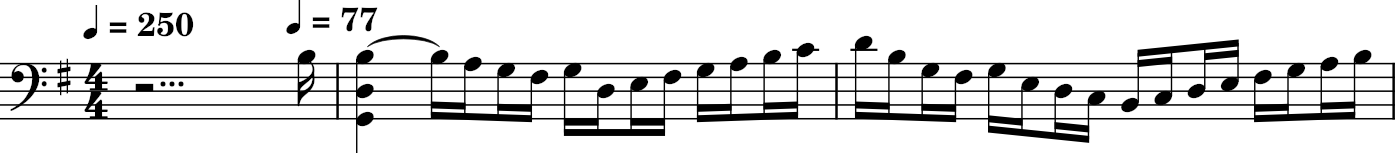

In [7]:
example_score.show()

In [8]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x1ea9b555bb0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77.0>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>

In [9]:
full_loader, note_to_int, duration_to_int, int_to_note, int_to_duration = prepare_data(
    file_list, SEQ_LEN + 1, BATCH_SIZE, PARSED_DATA_PATH, PARSE_MIDI_FILES
)
notes_vocab_size     = len(note_to_int)
durations_vocab_size = len(duration_to_int)

1 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-1pre.mid
2 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-2all.mid
3 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-3cou.mid
4 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-4sar.mid
5 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-5men.mid
6 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs1-6gig.mid
7 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs2-1pre.mid
8 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs2-2all.mid
9 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs2-3cou.mid
10 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs2-4sar.mid
11 Parsing D:\python_projects\pythonProject\Deep_Learning_Project\bach-cello\cs2-5men.mid
12 Parsing D:\pytho

In [10]:
full_dataset = full_loader.dataset
train_size   = int(0.9 * len(full_dataset))
val_size     = len(full_dataset) - train_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

In [11]:
batch_notes, batch_durs, batch_notes_tgt, batch_durs_tgt = next(iter(full_loader))
example_idx = 0 
note_idxs     = batch_notes[example_idx].tolist()
duration_idxs = batch_durs[example_idx].tolist()
example_notes     = [int_to_note[i]     for i in note_idxs]
example_durations = [int_to_duration[i] for i in duration_idxs]
print("\nNotes string:\n", example_notes, "…")
print("\nDurations string:\n", example_durations, "…")


Notes string:
 ['E-3', 'B-2', 'C3', 'D3', 'E-2', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'B-3', 'G3', 'G#3', 'G3', 'F3', 'G3', 'E-3', 'G3', 'G#3', 'B-3', 'G#3', 'B-3', 'E-4', 'C4', 'C#4', 'C4', 'B-3', 'C4', 'G#3', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'E-4', 'C4', 'C#4', 'C4', 'B-3', 'C4'] …

Durations string:
 ['0.5', '0.5', '0.5', '0.5', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5'] …


In [12]:
batch = next(iter(full_loader))
notes_batch, durs_batch, notes_tgt_batch, durs_tgt_batch = batch
N = 5  
print("{:<6} | {:<25} | {:<25}".format("Step", "Input (note, dur)", "Target (note, dur)"))
print("-" * 65)
for i in range(N):
    n_in  = notes_batch[0, i].item()
    d_in  = durs_batch[0,  i].item()
    n_tgt = notes_tgt_batch[0, i].item()
    d_tgt = durs_tgt_batch[0,  i].item()
    print("{:<6} | {:<12} {:<10} | {:<12} {:<10}".format(
        i,
        f"{n_in} ({int_to_note[n_in]})", f"{d_in} ({int_to_duration[d_in]})",
        f"{n_tgt} ({int_to_note[n_tgt]})", f"{d_tgt} ({int_to_duration[d_tgt]})"
    ))

Step   | Input (note, dur)         | Target (note, dur)       
-----------------------------------------------------------------
0      | 10 (B-3)     2 (0.5)    | 7 (A3)       2 (0.5)   
1      | 7 (A3)       2 (0.5)    | 51 (G3)      2 (0.5)   
2      | 51 (G3)      2 (0.5)    | 7 (A3)       2 (0.5)   
3      | 7 (A3)       2 (0.5)    | 44 (F3)      2 (0.5)   
4      | 44 (F3)      2 (0.5)    | 36 (E3)      2 (0.5)   


In [13]:
EPOCHS = 500
model = MusicTransformer(
    notes_vocab_size,
    durations_vocab_size,
    EMBEDDING_DIM,
    N_HEADS,
    KEY_DIM,
    FEED_FORWARD_DIM,
    DROPOUT_RATE
).to(device)

In [14]:
train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    device=device,
    notes_vocab_size=notes_vocab_size,
    durations_vocab_size=durations_vocab_size,
    generate_len=GENERATE_LEN,
    output_dir=OUTPUT_DIR,
    note_to_int=note_to_int,
    duration_to_int=duration_to_int,
    int_to_note=int_to_note,
    int_to_duration=int_to_duration,
    patience=50
)

C:\Users\hassa\miniconda3\envs\tf\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500 — Train: 4.6023 — Val: 3.7772
  ↳ New best model (val_loss=3.7772) saved.
Epoch 2/500 — Train: 3.5742 — Val: 3.2598
  ↳ New best model (val_loss=3.2598) saved.
Epoch 3/500 — Train: 3.1871 — Val: 3.0143
  ↳ New best model (val_loss=3.0143) saved.
Epoch 4/500 — Train: 3.0162 — Val: 2.8962
  ↳ New best model (val_loss=2.8962) saved.
Epoch 5/500 — Train: 2.9200 — Val: 2.8134
  ↳ New best model (val_loss=2.8134) saved.
Epoch 6/500 — Train: 2.8478 — Val: 2.7434
  ↳ New best model (val_loss=2.7434) saved.
Epoch 7/500 — Train: 2.7884 — Val: 2.6831
  ↳ New best model (val_loss=2.6831) saved.
Epoch 8/500 — Train: 2.7363 — Val: 2.6277
  ↳ New best model (val_loss=2.6277) saved.
Epoch 9/500 — Train: 2.6897 — Val: 2.5752
  ↳ New best model (val_loss=2.5752) saved.
Epoch 10/500 — Train: 2.6469 — Val: 2.5277
  ↳ New best model (val_loss=2.5277) saved.
Epoch 11/500 — Train: 2.6073 — Val: 2.4823
  ↳ New best model (val_loss=2.4823) saved.
Epoch 12/500 — Train: 2.5699 — Val: 2.4376
  ↳ New b

In [15]:
midi_stream, info = generate_music(
    model, ["START"], ["0.0"], max_tokens=100, temperature=0.5, device=device,
    int_to_note=int_to_note, int_to_duration=int_to_duration,
    notes_vocab_size=notes_vocab_size, durations_vocab_size=durations_vocab_size
)

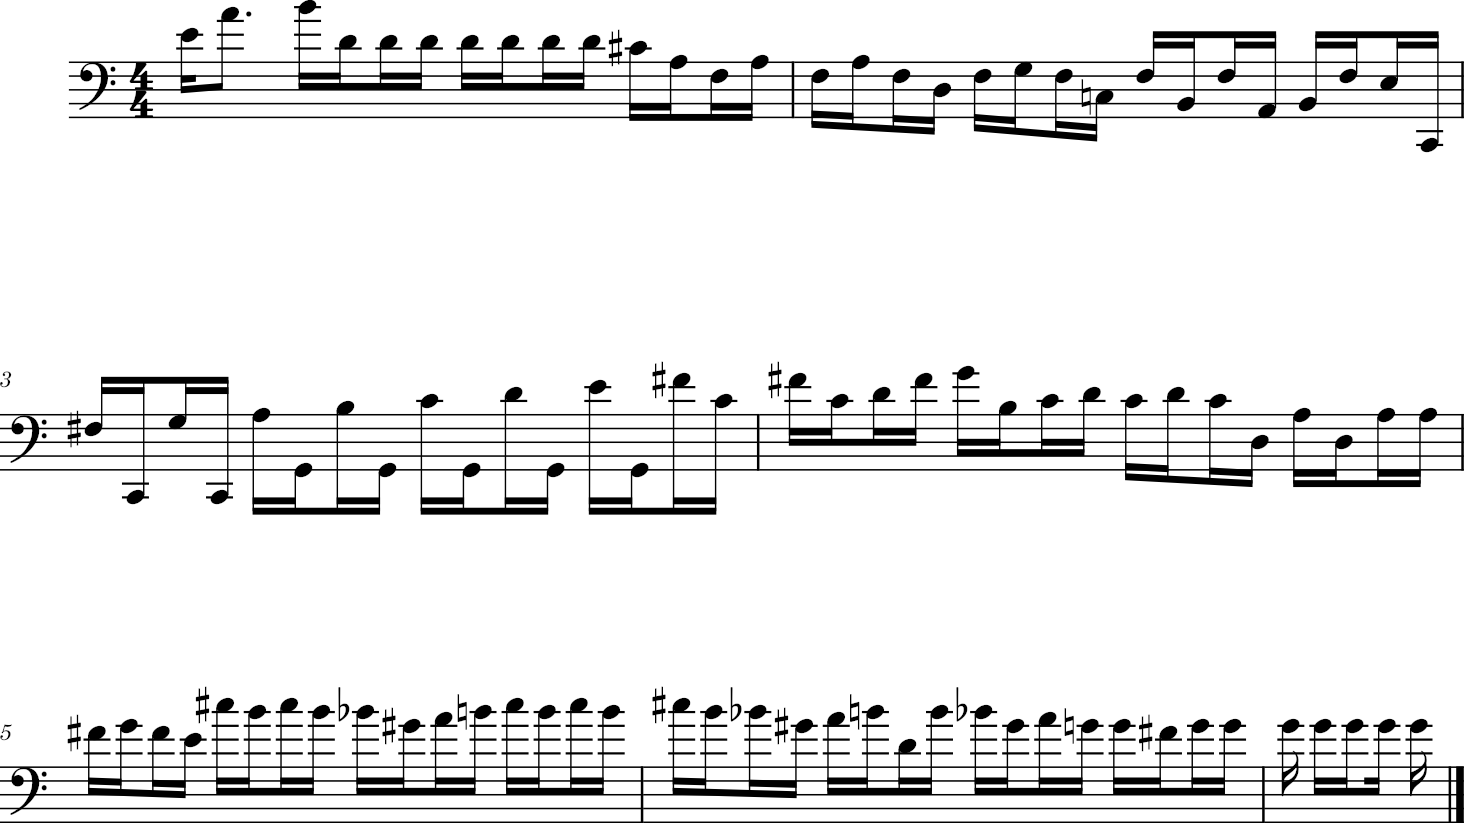

'D:\\python_projects\\pythonProject\\Deep_Learning_Project\\output\\generated_music.mid'

In [16]:
midi_stream.show()
midi_stream.write("midi", fp=os.path.join(OUTPUT_DIR, "generated_music.mid"))

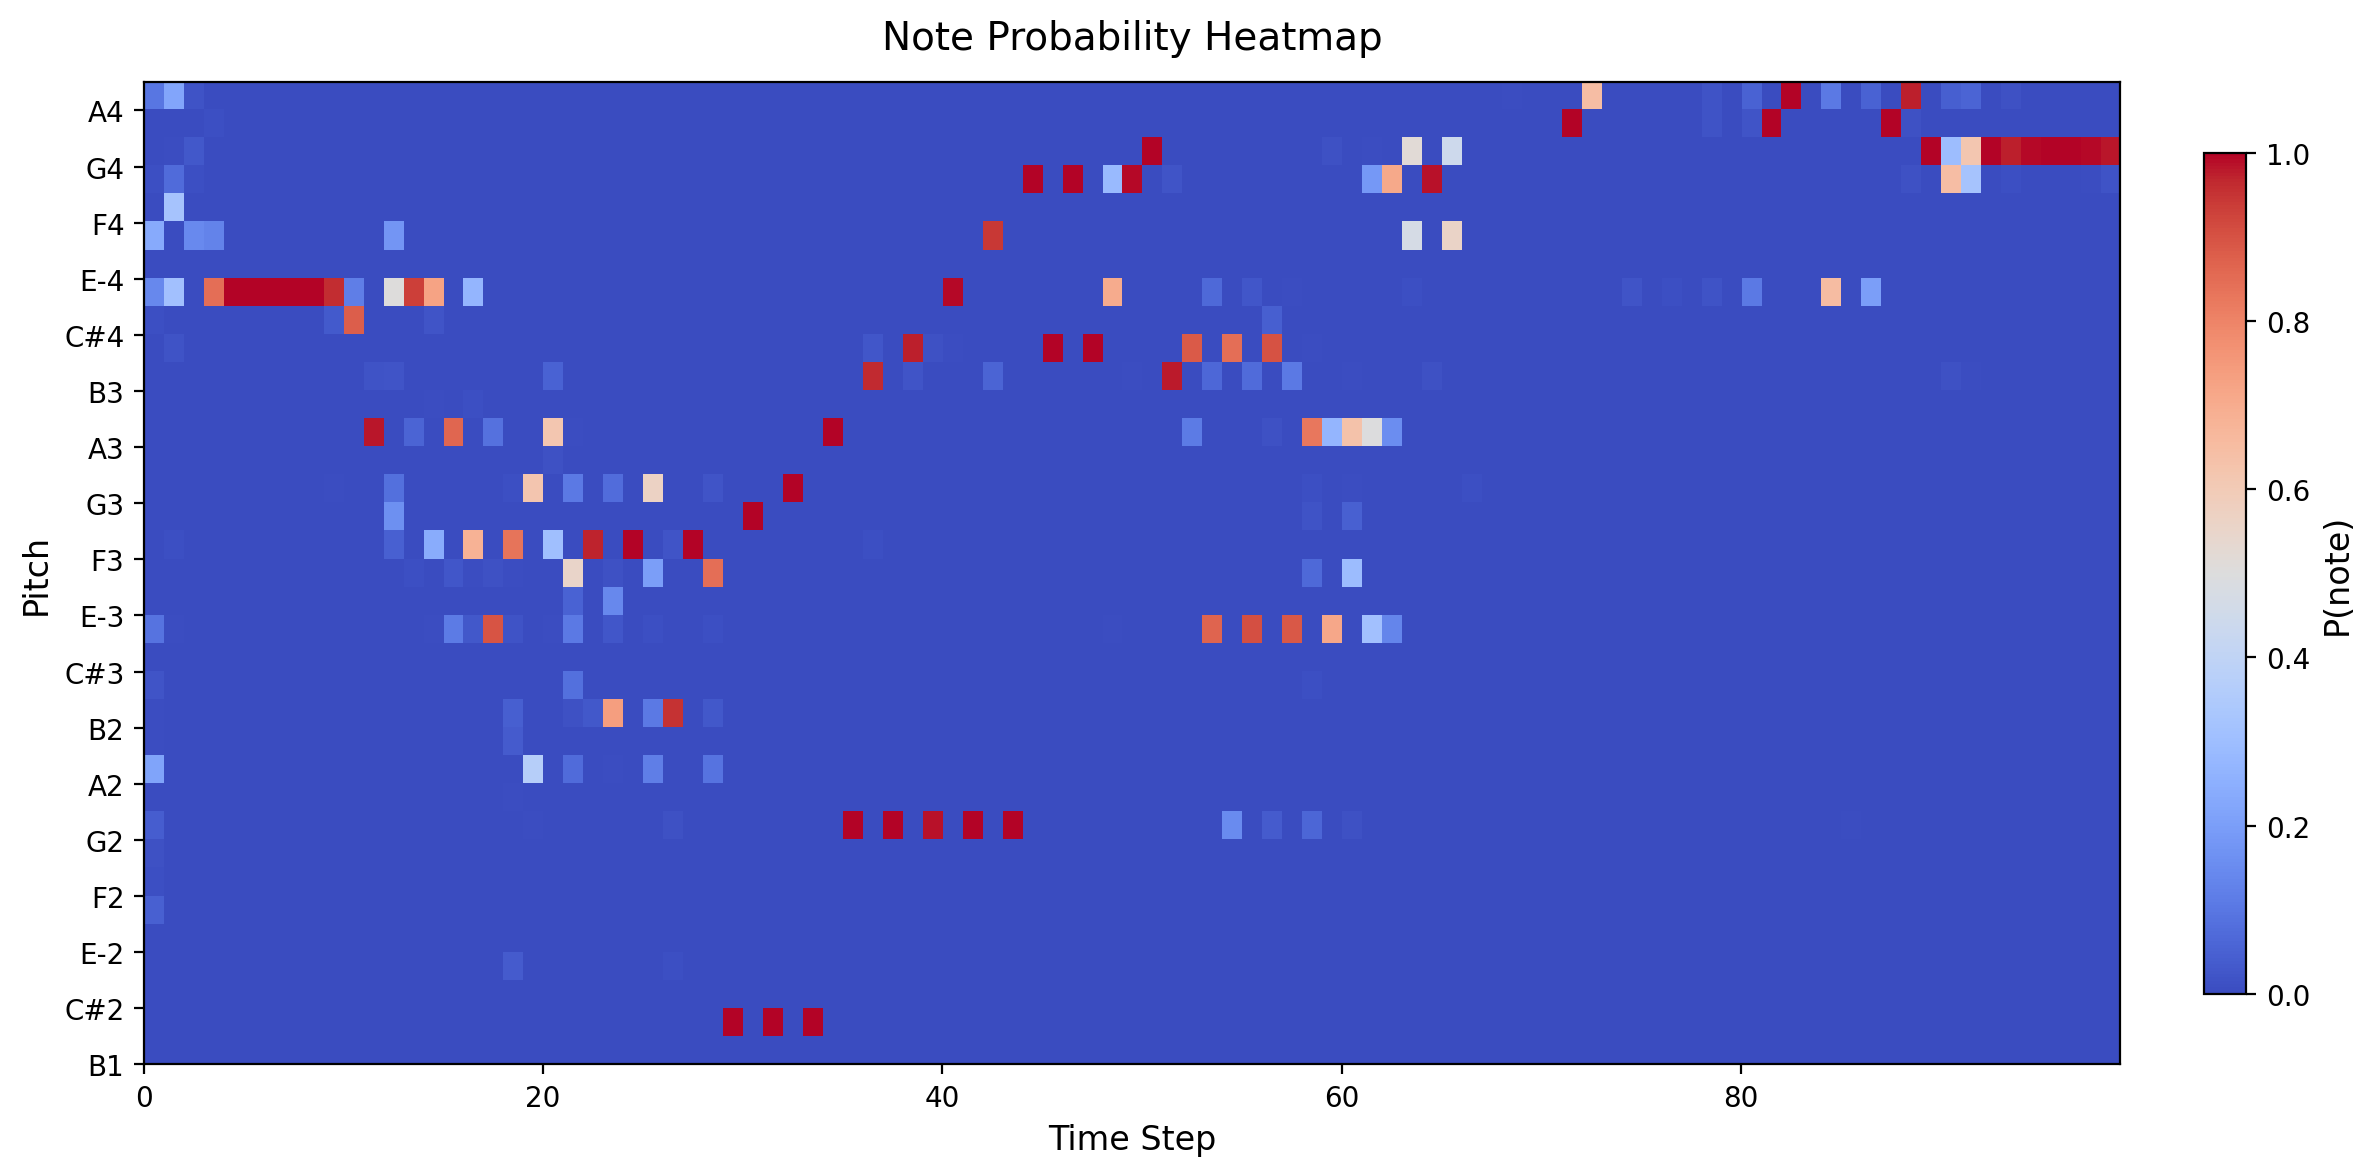

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import music21

# Parameters
max_pitch = 70
min_pitch = 35
seq_len = len(info)

# Build probability grid
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)
for t in range(seq_len):
    for idx, prob in enumerate(info[t]["note_probs"]):
        try:
            note_name = int_to_note[idx]
            midi_num  = music21.note.Note(note_name).pitch.midi
            if min_pitch <= midi_num < max_pitch:
                grid[midi_num, t] = prob
        except Exception:
            continue

subgrid = grid[min_pitch:max_pitch, :]
vmin, vmax = subgrid.min(), subgrid.max()

yticks = np.arange(min_pitch, max_pitch, 2)
ytick_labels = [music21.pitch.Pitch(n).nameWithOctave for n in yticks]

fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.imshow(
    subgrid,
    origin="lower",
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax,
    aspect="auto",
    extent=[0, seq_len, min_pitch, max_pitch]
)

ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Pitch",     fontsize=12)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=10)
ax.set_title("Note Probability Heatmap", fontsize=14, pad=12)

cb = fig.colorbar(cax, ax=ax, fraction=0.02, pad=0.04)
cb.set_label("P(note)", fontsize=12)

plt.tight_layout()
plt.show()


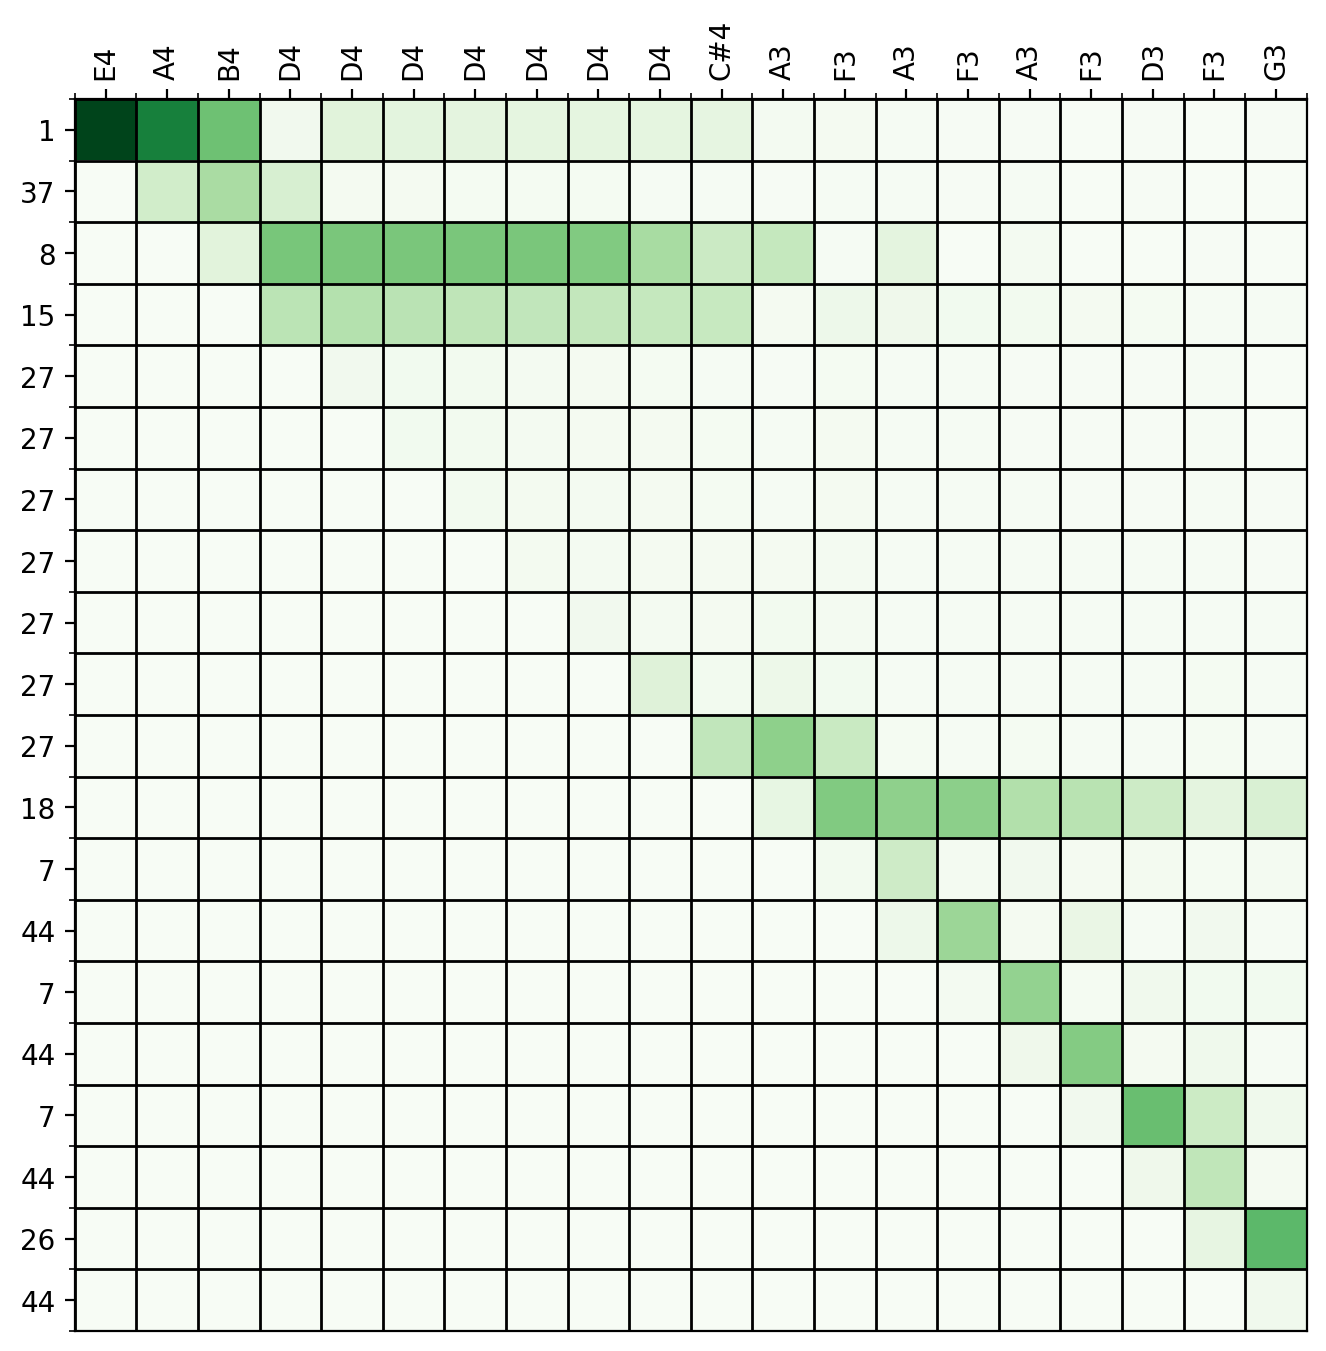

In [18]:
plot_size = min(20, len(info))
att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

for j in range(plot_size):
    atts = info[j]["atts"]
    att_matrix[: (j + 1), j] = atts[:j + 1]  # Ensure length matches j + 1
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1] if info[j]["prompt"][0] else "START")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()